In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import pickle
import pandas as pd
from estnltk import Text
from pandas import DataFrame
import re
import nltk
from nltk import word_tokenize
from multiprocessing import Pool, Manager, Process
import multiprocessing
import time
import math
from scipy import sparse
from scipy.sparse import lil_matrix
from tqdm import tqdm
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import gensim

### Download data: en and et

In [20]:
selected_data = pd.read_csv("C:/Users/Olha/Documents/Thesis/Extracted_data/selected_data_with_joined_text_column.csv", encoding='utf8')

In [21]:
# Delete index column

for i in selected_data.columns:
    if 'Unnamed' in i:
        del selected_data[i]

In [24]:
sel_col = ['link', 'node', 'lang_join', 'text_join']
data = selected_data[sel_col]

In [25]:
selected_data.head()

,link,node,description,productid,name,Lang1_description,Prob1_description,Text1_description,Lang1_name,Prob1_name,Text1_name,Lang1_productid,Prob1_productid,Text1_productid,lang_join,text_join
0,<http::tamberi.eu::/73-ehtekaardid::null::2017...,node6883b5caa683772129c48f93ac5e99,Null,NaN,Ehtekaart,None,None,None,et,0.9,Ehtekaart,NaN,NaN,NaN,et,Ehtekaart
1,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa,Akr\u00FC\u00FClv\u00E4rvid sisaldavad palju p...,NaN,"Akr\u00FC\u00FClv\u00E4rv, One Stroke, Phthalo...",et,0.99,AkruFCuFClvuErvid sisaldavad palju pigmenti on...,en,0.97,AkruFCuFClvuErv One Stroke Phthalo Green ml,NaN,NaN,NaN,en,AkruFCuFClvuErv One Stroke Phthalo Green ml
2,<http::www.kalastussport.ee::/136-taliridvad::...,nodef5d0383018d768c2279c3541adc8f1a,Null,NaN,Winter rod AKARA Legend,None,None,None,en,0.96,Winter rod AKARA Legend,NaN,NaN,NaN,en,Winter rod AKARA Legend
3,<https::www.paradiis.ee::/et/128-kampaania::p=...,noded2b1c726cca5417aadf2c82e333d51b6,See esinduslik aiam\u00F6\u00F6bel on valmist...,NaN,PEARL AIAM\u00D6\u00D6BEL,et,0.98,See esinduslik aiamuFuFbel on valmistatud rom...,gd,0.94,PEARL AIAMuDuDBEL,NaN,NaN,NaN,et,See esinduslik aiamuFuFbel on valmistatud rom...
4,<http::www.ittgroup.ee::/en/new-products::null...,nodefeb891dd8590e0d85f9c685e4642449,Null,NaN,Digital pressure sensor BMP280,None,None,None,en,0.96,Digital pressure sensor BMP,NaN,NaN,NaN,en,Digital pressure sensor BMP


In [6]:
en_data = data[data['lang_join'] == 'en']
del en_data['lang_join']
en_data.reset_index(drop=True, inplace=True)

et_data = data[data['lang_join'] == 'et']
del et_data['lang_join']
et_data.reset_index(drop=True, inplace=True)

In [7]:
en_data.shape

(187105, 3)

In [8]:
et_data.shape

(134484, 3)

### Apply POS tagging

#### For English

In [9]:
en_nouns_tags = ['NN', 'NNS', 'NNP', 'NNPS']

def en_tag(text_raw):
    new_text = []
    text = word_tokenize(text_raw)
    pos_tags = nltk.pos_tag(text)
    for j in range(len(pos_tags)):
        if pos_tags[j][1] in en_nouns_tags:
            new_text.append(pos_tags[j][0])
    return new_text

en_data['Nouns'] = en_data["text_join"].apply(lambda x: en_tag(x))

C:\Users\Olha\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [10]:
en_data.head()

,link,node,text_join,Nouns
0,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa,AkruFCuFClvuErv One Stroke Phthalo Green ml,"[AkruFCuFClvuErv, Stroke, Phthalo, Green, ml]"
1,<http::www.kalastussport.ee::/136-taliridvad::...,nodef5d0383018d768c2279c3541adc8f1a,Winter rod AKARA Legend,"[Winter, rod, AKARA, Legend]"
2,<http::www.ittgroup.ee::/en/new-products::null...,nodefeb891dd8590e0d85f9c685e4642449,Digital pressure sensor BMP,"[Digital, pressure, sensor, BMP]"
3,<http::www.ittgroup.ee::/en/31-converters::nul...,node67109f1f1de73f41d2979d4561221,Analogdigital converter bit ADS,"[converter, bit, ADS]"
4,<http::www.ittgroup.ee::/en/38-prototyping-and...,node3f349ca61d31b5f8c6bfe56bdb8081,Power Charger VA,"[Power, Charger, VA]"


#### For Estonian

In [11]:
et_nouns_tags = ['H', 'S']

def et_tag(text_raw):
    new_text = []
    text = Text(text_raw)
    postags_est = text.get.postags.as_dataframe
    for i in range(len(postags_est)):
        try:
            if postags_est.postags[i] in et_nouns_tags:
                new_text.append(text.words[i]['text'])
        except:
            print(text_raw, postags_est, i)
    return new_text

et_data['Nouns'] = et_data["text_join"].apply(lambda x: et_tag(x))

C:\Users\Olha\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [12]:
et_data.head()

,link,node,text_join,Nouns
0,<http::tamberi.eu::/73-ehtekaardid::null::2017...,node6883b5caa683772129c48f93ac5e99,Ehtekaart,[Ehtekaart]
1,<https::www.paradiis.ee::/et/128-kampaania::p=...,noded2b1c726cca5417aadf2c82e333d51b6,See esinduslik aiamuFuFbel on valmistatud rom...,"[aiamuFuFbel, lossipargi, stiilis]"
2,<https::aiakaubad.ee::/84-telgid::null::201708...,nodeaeeb8b6ba62b6f3fd2eafc75ce1f36c,Alumiiniumtoru luEbimuFuFt uD uAuDcm uDClemis...,"[Alumiiniumtoru, luEbimuFuFt, uAuDcm, uDClemis..."
3,<https::vibes.ee::/et/13-vibraatorid::null::20...,node38302f399536504988c1d1b4703df497,Nutikas sensoriga armukuul mida saad juhtida a...,"[sensoriga, armukuul, treening, lelu, aru, lih..."
4,<https::vibes.ee::/et/750-vibraatormunad::null...,node8a81eac4ed95140bdb38ef9291fb4c8,Juhtmevaba pildiga vibraatormuna millega omale...,"[pildiga, vibraatormuna, omale, vuFi, naudingu..."


### Delete duplicates

In [13]:
def joined(text):
    new_text = " ".join(text)
    return new_text

et_data["Nouns"] = et_data["Nouns"].apply(lambda x: joined(x))
en_data["Nouns"] = en_data["Nouns"].apply(lambda x: joined(x))

C:\Users\Olha\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Olha\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [29]:
# investigate duplicates

from collections import Counter
def duplicates(data):
    all_nouns = []
    for i in data["Nouns"]:
        all_nouns.append(i)
    uniq = Counter(all_nouns)
    return uniq

en = duplicates(en_data)
et = duplicates(et_data)

In [30]:
en

Counter({'AkruFCuFClvuErv Stroke Phthalo Green ml': 2,
         'Winter rod AKARA Legend': 3,
         'Digital pressure sensor BMP': 3,
         'converter bit ADS': 1,
         'Power Charger VA': 1,
         'Braun Series cc WetDry Foil shaver HuFbe Patarei V Series cc WetDry Foil shaver': 1,
         'pisiXBee ATxmegaAU board': 1,
         'unit FODTD': 4,
         'AkruFCuFClvuErv Stroke Royal Gold ml': 2,
         'Soft Lip Balm Lemon g': 18,
         'Trillium XLuAis amazinguAtriple hammock hardcore hammock market Reinforced meters seat belt heavyduty ratchets safety stability comfort course views outdoors': 32,
         'Veiniriiul': 30,
         'Musucbag sleeping bag peopleSelkBag Kids': 23,
         'ELVF access control time attendance access control system size businesses securityFingerprint lock ELVF': 3,
         'Voltage Regulator V mA': 1,
         'System cylinder oval Valnes EC': 1,
         'locks mountsDoorknob chrome VALSCZNC': 2,
         'Olavinlinna CastleAerial

In [31]:
d = 'Mizon Original Skin Energy Hyaluronic Acid'
en_data[en_data.Nouns == d]

,link,node,text_join,Nouns
103,<http::koreacosmetics.eu::/en/::null::20170818...,node7694bf4bc8903cbbefc3717e2a62ed70,Mizon Original Skin Energy Hyaluronic Acid,Mizon Original Skin Energy Hyaluronic Acid
1154,<http::koreacosmetics.eu::/et/::null::20170818...,node9be298211e93b0b8324b7b3a624517d8,Mizon Original Skin Energy Hyaluronic Acid,Mizon Original Skin Energy Hyaluronic Acid
2934,<http::koreacosmetics.eu::/et/42-seerum::null:...,node605272e0dbbd46cbd42a32349b0e277,Mizon Original Skin Energy Hyaluronic Acid,Mizon Original Skin Energy Hyaluronic Acid
18099,<http::koreacosmetics.eu::/en/::null::20170822...,nodec769caa6c840f9f996e2e547b3ad7a,Mizon Original Skin Energy Hyaluronic Acid,Mizon Original Skin Energy Hyaluronic Acid
18842,<http::koreacosmetics.eu::/et/::null::20170822...,nodef550471c9f177fca6ed5846b68151c,Mizon Original Skin Energy Hyaluronic Acid,Mizon Original Skin Energy Hyaluronic Acid
23280,<http::koreacosmetics.eu::/en/42-serum::null::...,node50c788ba6826712e1d3769fc8145049,Mizon Original Skin Energy Hyaluronic Acid,Mizon Original Skin Energy Hyaluronic Acid
24605,<http::koreacosmetics.eu::/et/::dispatch=produ...,nodeb492653bb18444472b93839fdc9afe2,Mizon Original Skin Energy Hyaluronic Acid,Mizon Original Skin Energy Hyaluronic Acid
34282,<http::koreacosmetics.eu::/ru/42-serum-syvorot...,node9b10fb54151c40f06223a9cd3e1ca48b,Mizon Original Skin Energy Hyaluronic Acid,Mizon Original Skin Energy Hyaluronic Acid
63844,<http::koreacosmetics.eu::/ru/::null::20170818...,nodecba05f8f87bdfb561acdae9b7534fa3,Mizon Original Skin Energy Hyaluronic Acid,Mizon Original Skin Energy Hyaluronic Acid
67702,<http::koreacosmetics.eu::/en/::null::20170818...,node783875e781d22171de347b2c691d7910,Mizon Original Skin Energy Hyaluronic Acid,Mizon Original Skin Energy Hyaluronic Acid


In [32]:
et

Counter({'Ehtekaart': 40,
         'aiamuFuFbel lossipargi stiilis': 1,
         'Alumiiniumtoru luEbimuFuFt uAuDcm uDClemised torud uDmm KuFCljed Kangas Oxford VuErv vuFi': 6,
         'sensoriga armukuul treening lelu aru lihased treeningimpulsseNuEed lihased Gballs': 12,
         'pildiga vibraatormuna omale vuFi naudingut pakkudaVibratsiooniga armukuul Shiver': 8,
         'LihvivaduAkaks kordauAkiiremini tavaviilistuAneli disain viili bumerangina viilinauAViili kuju pinnatuFuFtlus mugavustunde kliendile viilimne massaazinauAViili katteks Jaapani Fuji': 6,
         'Moodsa disainiga diivanvoodi CATRINE DIIVANVOODI': 4,
         'JULIETTA RIIDEKAPP': 3,
         'MuFuFblikomplekt ELEGANTE Komplekti tugitool kuEetugedeta moodul nurgamoodul tumba laud VuErv Punutis rotangist Konstruktsioon alumiiniumist raam Istmepadjad seljatoed AiamuFuFbel komplekt ELEGANTE': 7,
         'ANTILIA DIIVANVOODI': 5,
         'Elektrivasturaud pidevvooluga': 7,
         'mikro kaardi moodul': 4,
       

In [36]:
d = 'Majapidamispaberi hoidja'
et_data[et_data.Nouns == d]

,link,node,text_join,Nouns
65,<http::www.freshdesign.ee::/104-majapidamispab...,node25fc15ac82f7d722868d7346fd632fc,Majapidamispaberi hoidja,Majapidamispaberi hoidja
171,<http::www.freshdesign.ee::/104-majapidamispab...,node42d2b6c524e1267497d795fe510eab5,Majapidamispaberi hoidja,Majapidamispaberi hoidja
268,<http::www.freshdesign.ee::/104-majapidamispab...,nodeffeb31a6c421d2872276ca8698e2ace,Majapidamispaberi hoidja,Majapidamispaberi hoidja
357,<http::www.freshdesign.ee::/104-majapidamispab...,node3f525d3ea1c25a83b58e8a7acfb2685c,Majapidamispaberi hoidja,Majapidamispaberi hoidja
618,<http::www.freshdesign.ee::/104-majapidamispab...,nodeb097e22e4fa492fa318357cc1cd47c4,Majapidamispaberi hoidja,Majapidamispaberi hoidja
895,<http::www.freshdesign.ee::/104-majapidamispab...,nodee44814235a867e56653432a73ec6fe11,Majapidamispaberi hoidja,Majapidamispaberi hoidja
1086,<http::www.freshdesign.ee::/104-majapidamispab...,node4be0fb4fe68ebb9e3a22d8b4ad07f,Majapidamispaberi hoidja,Majapidamispaberi hoidja
1134,<http::www.freshdesign.ee::/104-majapidamispab...,node7a4857e41f39fe251d7ea59b88383a,Majapidamispaberi hoidja,Majapidamispaberi hoidja
1285,<http::www.freshdesign.ee::/104-majapidamispab...,node6fdf2c748abb7d0338efcc8e4a5ea6,Majapidamispaberi hoidja,Majapidamispaberi hoidja
1295,<http::www.freshdesign.ee::/104-majapidamispab...,node3e6761ed7e9e96b29b20e9836e5df36,Majapidamispaberi hoidja,Majapidamispaberi hoidja


In [16]:
# delete duplicates

def reduce_duplicates(data):
    all_nouns = data["Nouns"]
    unique_nouns = all_nouns.unique()
    print("Amount of unique texts: ", float(100*float(len(unique_nouns))/float(len(all_nouns))), '%')
    return unique_nouns

unique_nouns_en = reduce_duplicates(en_data)
unique_nouns_et = reduce_duplicates(et_data)

Amount of unique texts:  23.158119772320354 %
Amount of unique texts:  23.08304333601023 %


#### Save / Load data

In [2]:
#et_data.to_csv('et_data.csv')
#en_data.to_csv('en_data.csv')
en_data = pd.read_csv('en_data.csv')
et_data = pd.read_csv('et_data.csv')

In [58]:
'''
with open('unique_nouns_en', 'wb') as fp:
    pickle.dump(unique_nouns_en, fp)
with open('unique_nouns_et', 'wb') as fp:
    pickle.dump(unique_nouns_et, fp)
'''
with open ('unique_nouns_en', 'rb') as fp:
    unique_nouns_en = pickle.load(fp)
with open ('unique_nouns_et', 'rb') as fp:
    unique_nouns_et = pickle.load(fp)

### Apply Doc2Vec

#### For English

In [21]:
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(unique_nouns_en)]
model.build_vocab(tagged_data)

for epoch in tqdm(range(max_epochs)):
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v_en.model")
print("Model Saved")

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [34:38<00:00, 22.01s/it]


Model Saved


#### For Estonian

In [22]:
model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)

tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(unique_nouns_et)]
model.build_vocab(tagged_data)

for epoch in tqdm(range(max_epochs)):
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v_et.model")
print("Model Saved")

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [16:24<00:00,  9.25s/it]


Model Saved


#### Load models

In [18]:
model_en = Doc2Vec.load("d2v_en.model")
model_et = Doc2Vec.load("d2v_et.model")

In [3]:
#path = 'C:/Users/Olha/Documents/GoogleNews-vectors-negative300.bin'
#word2vec_en = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)

### Clusterization

#### Vectorization with pre-trained models

In [55]:
#Load data

en_data = pd.read_csv('en_data.csv')
et_data = pd.read_csv('et_data.csv')
for i in en_data.columns:
    if 'Unnamed' in i:
        del en_data[i]
for i in et_data.columns:
    if 'Unnamed' in i:
        del et_data[i]
en_data = en_data[~pd.isnull(en_data['Nouns'])]
et_data = et_data[~pd.isnull(et_data['Nouns'])]

#### Using distance matrix and DBSCAN

In [56]:
def calc_distance(size, model):
    coo = lil_matrix ((size, size))
    distance = coo.tocsr()
    for i in tqdm(range(size)):
        similar_doc = model.docvecs.most_similar([model.docvecs[i]])
        for j in range(len(similar_doc)):
            distance[i, int(similar_doc[j][0])] = float(similar_doc[j][1])
    return distance

In [47]:
distance_en = calc_distance(len(unique_nouns_en), model_en)
distance_et = calc_distance(len(unique_nouns_et), model_et)

  0%|                                                                                        | 0/43330 [00:00<?, ?it/s]C:\Users\Olha\Anaconda3\lib\site-packages\scipy\sparse\compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
100%|████████████████████████████████████████████████████████████████████████████| 31043/31043 [28:00<00:00,  9.61it/s]


In [39]:
#sparse.save_npz("distance_en.npz", distance_en)
#sparse.save_npz("distance_et.npz", distance_et)
distance_en = sparse.load_npz("distance_en.npz")
distance_et = sparse.load_npz("distance_et.npz")

#### Perform DBSCAN

In [45]:
def explore_clusters(clustering):
    core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
    core_samples_mask[clustering.core_sample_indices_] = True
    labels = clustering.labels_

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    #print('Estimated number of clusters: %d' % n_clusters_)
    #print('Estimated number of noise points: %d' % n_noise_)
    
    return n_clusters_, n_noise_

#### For English

In [5]:
distance_et.shape[0]

31043

In [4]:
round(math.log(distance_en.shape[0]))

11

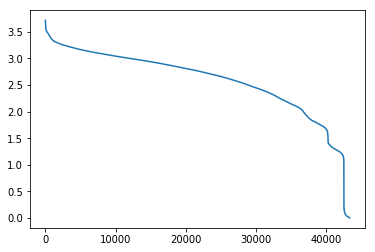

In [4]:
s = 3
nbrs = NearestNeighbors(n_neighbors=s).fit(distance_en)
distances, indices = nbrs.kneighbors(distance_en)
distanceDec = sorted(distances[:,s-1], reverse=True)
plt.plot(indices[:,0], distanceDec)

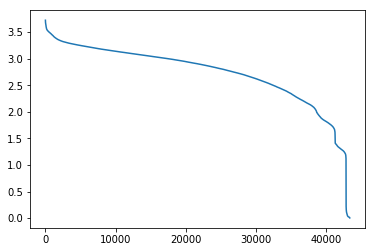

In [5]:
s = 4
nbrs = NearestNeighbors(n_neighbors=s).fit(distance_en)
distances, indices = nbrs.kneighbors(distance_en)
distanceDec = sorted(distances[:,s-1], reverse=True)
plt.plot(indices[:,0], distanceDec)

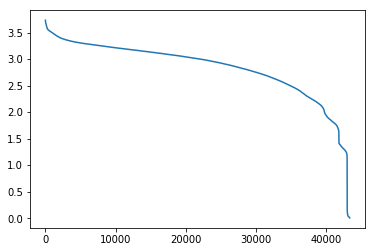

In [8]:
s = 5
nbrs = NearestNeighbors(n_neighbors=s).fit(distance_en)
distances, indices = nbrs.kneighbors(distance_en)
distanceDec = sorted(distances[:,s-1], reverse=True)
plt.plot(indices[:,0], distanceDec)

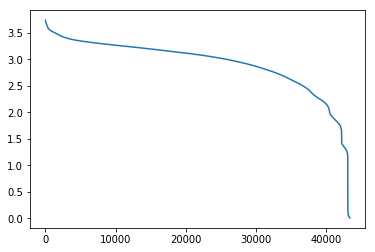

In [9]:
s = 6
nbrs = NearestNeighbors(n_neighbors=s).fit(distance_en)
distances, indices = nbrs.kneighbors(distance_en)
distanceDec = sorted(distances[:,s-1], reverse=True)
plt.plot(indices[:,0], distanceDec)

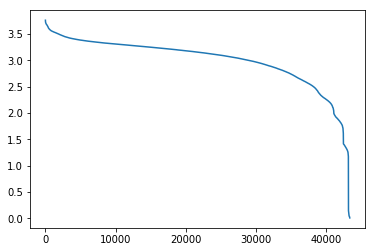

In [10]:
s = 7
nbrs = NearestNeighbors(n_neighbors=s).fit(distance_en)
distances, indices = nbrs.kneighbors(distance_en)
distanceDec = sorted(distances[:,s-1], reverse=True)
plt.plot(indices[:,0], distanceDec)

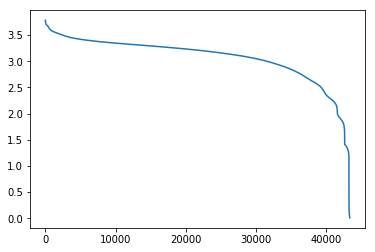

In [11]:
s = 8
nbrs = NearestNeighbors(n_neighbors=s).fit(distance_en)
distances, indices = nbrs.kneighbors(distance_en)
distanceDec = sorted(distances[:,s-1], reverse=True)
plt.plot(indices[:,0], distanceDec)

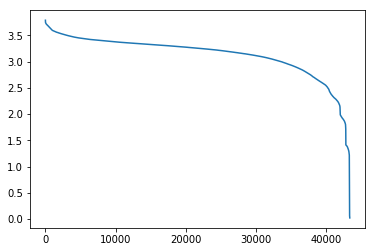

In [12]:
s = 9
nbrs = NearestNeighbors(n_neighbors=s).fit(distance_en)
distances, indices = nbrs.kneighbors(distance_en)
distanceDec = sorted(distances[:,s-1], reverse=True)
plt.plot(indices[:,0], distanceDec)

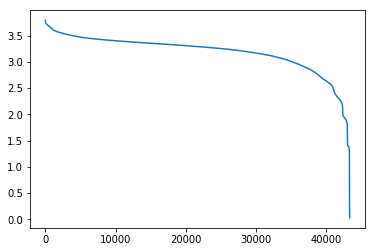

In [13]:
s = 10
nbrs = NearestNeighbors(n_neighbors=s).fit(distance_en)
distances, indices = nbrs.kneighbors(distance_en)
distanceDec = sorted(distances[:,s-1], reverse=True)
plt.plot(indices[:,0], distanceDec)

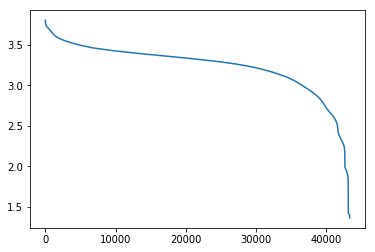

In [14]:
s = 11
nbrs = NearestNeighbors(n_neighbors=s).fit(distance_en)
distances, indices = nbrs.kneighbors(distance_en)
distanceDec = sorted(distances[:,s-1], reverse=True)
plt.plot(indices[:,0], distanceDec)

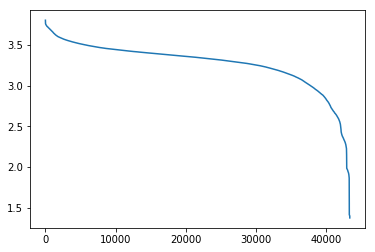

In [40]:
s = 12
nbrs = NearestNeighbors(n_neighbors=s).fit(distance_en)
distances, indices = nbrs.kneighbors(distance_en)
distanceDec = sorted(distances[:,s-1], reverse=True)
plt.plot(indices[:,0], distanceDec)

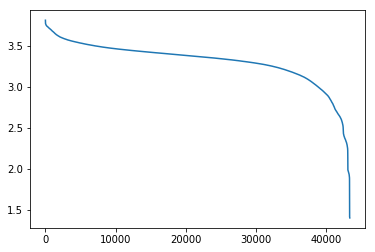

In [41]:
s = 13
nbrs = NearestNeighbors(n_neighbors=s).fit(distance_en)
distances, indices = nbrs.kneighbors(distance_en)
distanceDec = sorted(distances[:,s-1], reverse=True)
plt.plot(indices[:,0], distanceDec)

In [17]:
clusters2 = []
noises2 = []
e = 2
for s in range(3,5):
    clustering_en = DBSCAN(eps=e, min_samples=s).fit(distance_en)
    c, n = explore_clusters(clustering_en)
    clusters2.append(c)
    noises2.append(n)

In [18]:
clusters25 = []
noises25 = []
e = 2.5
for s in range(5,11):
    clustering_en = DBSCAN(eps=e, min_samples=s).fit(distance_en)
    c, n = explore_clusters(clustering_en)
    clusters25.append(c)
    noises25.append(n)

In [19]:
clusters3 = []
noises3 = []
e = 3
s = 11
clustering_en = DBSCAN(eps=e, min_samples=s).fit(distance_en)
c, n = explore_clusters(clustering_en)
clusters3.append(c)
noises3.append(n)

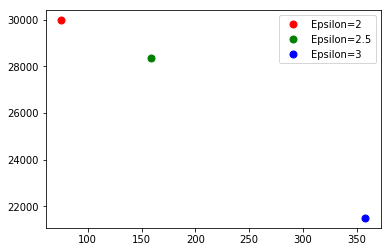

In [49]:
clusters = []
noises = []
s = 12
for e in [2, 2.5, 3]:
    clustering_et = DBSCAN(eps=e, min_samples=s).fit(distance_et)
    c, n = explore_clusters(clustering_et)
    clusters.append(c)
    noises.append(n)
plt.plot(clusters[0], noises[0], marker='o', markersize=7, color='r', linestyle='', label='Epsilon=2')
plt.plot(clusters[1], noises[1], marker='o', markersize=7, color='g', linestyle='', label='Epsilon=2.5')
plt.plot(clusters[2], noises[2], marker='o', markersize=7, color="b", linestyle='', label='Epsilon=3')
plt.legend(fontsize='medium')
#plt.xlabel('Number of clusters')
#plt.ylabel("Number of noise")

In [40]:
# Best clustering for English

e = 3
s = 11
clustering_en = DBSCAN(eps=e, min_samples=s).fit(distance_en)
c, n = explore_clusters(clustering_en)
print("Number of clusters: ", c)
print("Proportion of noise: ", n/distance_en.shape[0]*100)

Number of clusters:  626
Proportion of noise:  68.562197092084


In [66]:
DataEn = {'Nouns_unique':  unique_nouns_en, 'Cluster': clustering_en.labels_}

df_clusters_en = DataFrame (DataEn, columns = ['Nouns_unique', 'Cluster'])

In [73]:
en_results = pd.merge(en_data, df_clusters_en, how = 'left', left_on='Nouns', right_on='Nouns_unique')
en_results = en_results.drop(columns=['Nouns_unique'])

In [74]:
en_results.head(10)

,link,node,text_join,Nouns,Cluster
0,<https::nailin.ee::/et/27-akruulvarvid::null::...,node517e8478b3641044f1e2e2bbc31afa,AkruFCuFClvuErv One Stroke Phthalo Green ml,AkruFCuFClvuErv Stroke Phthalo Green ml,0
1,<http::www.kalastussport.ee::/136-taliridvad::...,nodef5d0383018d768c2279c3541adc8f1a,Winter rod AKARA Legend,Winter rod AKARA Legend,271
2,<http::www.ittgroup.ee::/en/new-products::null...,nodefeb891dd8590e0d85f9c685e4642449,Digital pressure sensor BMP,Digital pressure sensor BMP,-1
3,<http::www.ittgroup.ee::/en/31-converters::nul...,node67109f1f1de73f41d2979d4561221,Analogdigital converter bit ADS,converter bit ADS,-1
4,<http::www.ittgroup.ee::/en/38-prototyping-and...,node3f349ca61d31b5f8c6bfe56bdb8081,Power Charger VA,Power Charger VA,16
5,<https::fokus.ee::/et/::null::20170817124648,node235acd40d8daf1d27f65d9dd78c59e9f,Braun Series cc WetDry Foil shaver HuFbe Pata...,Braun Series cc WetDry Foil shaver HuFbe Patar...,-1
6,<http::www.ittgroup.ee::/en/25-micrcontroller-...,nodeefb1bbc8c8a29d4d2b11b41512c3a,pisiXBee ATxmegaAU board,pisiXBee ATxmegaAU board,1
7,<https::valnes.ee::/tooted/en/141-doorphones::...,node6468abd594ffd213895d25a99d6f1eb,indoor unit FODTD,unit FODTD,2
8,<https::nailin.ee::/et/27-akruulvarvid::null::...,node2358d41764fd1e9da5191d9759bc62,AkruFCuFClvuErv One Stroke Royal Gold ml,AkruFCuFClvuErv Stroke Royal Gold ml,-1
9,<http::koreacosmetics.eu::/et/14-make-up::null...,nodea94070cf962ee9737c02e9c24bfc52,Baviphat Soft Lip Balm Lemon g,Soft Lip Balm Lemon g,-1


In [88]:
en_results.to_csv('Results/en_data_dbscan.csv',index=False)

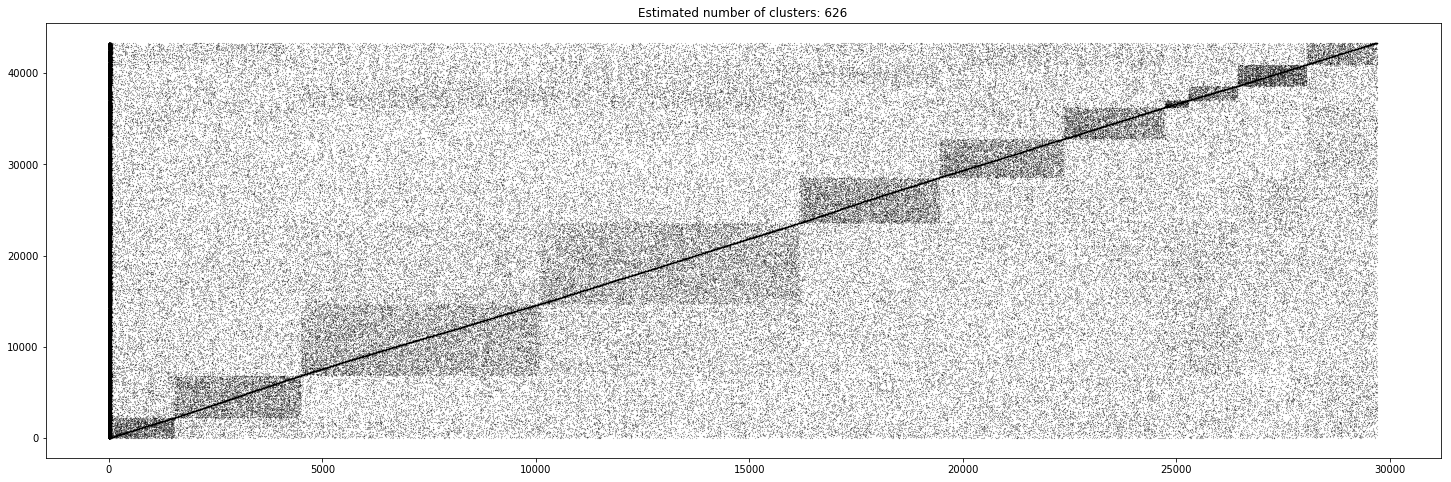

In [47]:
# Plot result

# Black removed and is used for noise instead.
unique_labels = set(clustering_en.labels_)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
core_samples_mask = np.zeros_like(clustering_en.labels_, dtype=bool)
plt.figure(figsize=(25, 8))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (clustering_en.labels_ == k)

    xy = distance_en[class_member_mask & core_samples_mask]
    #print(xy.nonzero()[0])
    plt.plot(xy.nonzero()[0], xy.nonzero()[1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=0.1)

    xy = distance_en[class_member_mask & ~core_samples_mask]
    plt.plot(xy.nonzero()[0], xy.nonzero()[1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=0.1)

plt.title('Estimated number of clusters: %d' % c)
plt.show()

#### For Estonian

In [90]:
round(math.log(distance_et.shape[0]))

10

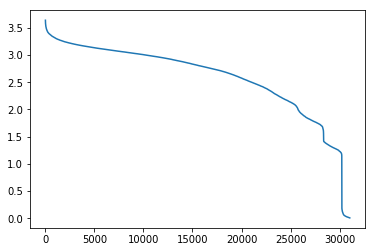

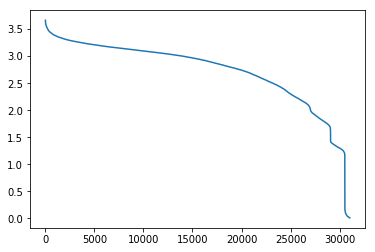

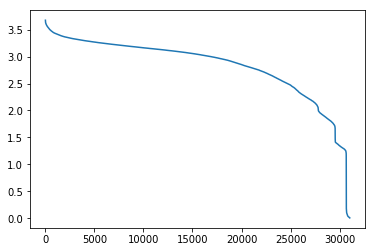

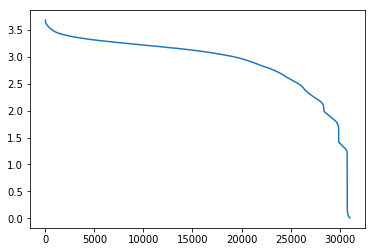

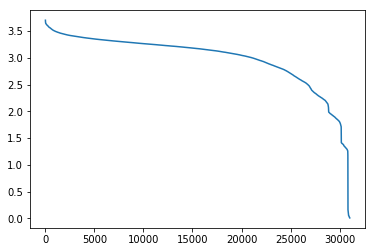

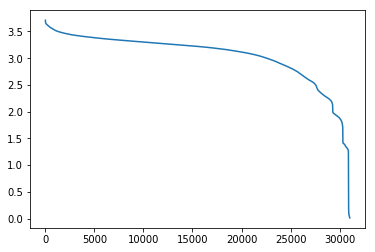

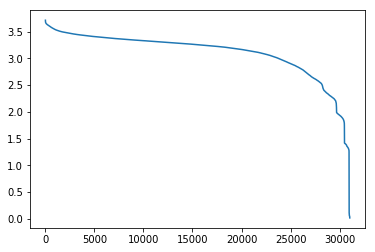

In [92]:
for s in range(3, round(math.log(distance_et.shape[0]))):
    nbrs = NearestNeighbors(n_neighbors=s).fit(distance_et)
    distances, indices = nbrs.kneighbors(distance_et)
    distanceDec = sorted(distances[:,s-1], reverse=True)
    plt.plot(indices[:,0], distanceDec)
    plt.show()

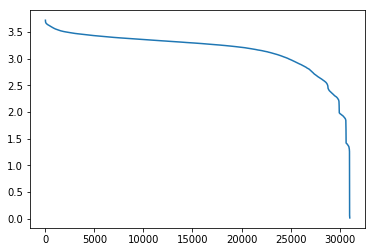

In [93]:
s = round(math.log(distance_et.shape[0]))
nbrs = NearestNeighbors(n_neighbors=s).fit(distance_et)
distances, indices = nbrs.kneighbors(distance_et)
distanceDec = sorted(distances[:,s-1], reverse=True)
plt.plot(indices[:,0], distanceDec)

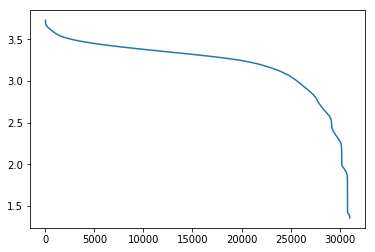

In [42]:
s = 11
nbrs = NearestNeighbors(n_neighbors=s).fit(distance_et)
distances, indices = nbrs.kneighbors(distance_et)
distanceDec = sorted(distances[:,s-1], reverse=True)
plt.plot(indices[:,0], distanceDec)

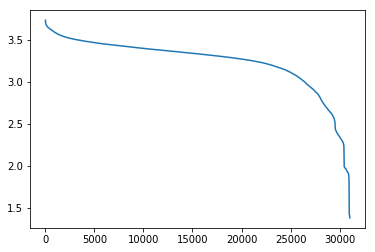

In [43]:
s = 12
nbrs = NearestNeighbors(n_neighbors=s).fit(distance_et)
distances, indices = nbrs.kneighbors(distance_et)
distanceDec = sorted(distances[:,s-1], reverse=True)
plt.plot(indices[:,0], distanceDec)

In [94]:
clusters2 = []
noises2 = []
e = 2
for s in range(3,5):
    clustering_et = DBSCAN(eps=e, min_samples=s).fit(distance_et)
    c, n = explore_clusters(clustering_et)
    clusters2.append(c)
    noises2.append(n)

In [102]:
clusters25 = []
noises25 = []
e = 2.5
for s in range(5,round(math.log(distance_et.shape[0]))+1):
    clustering_et = DBSCAN(eps=e, min_samples=s).fit(distance_et)
    c, n = explore_clusters(clustering_et)
    clusters25.append(c)
    noises25.append(n)

In [105]:
clusters3 = []
noises3 = []
e = 3
for s in range(5,round(math.log(distance_et.shape[0]))+1):
    clustering_et = DBSCAN(eps=e, min_samples=s).fit(distance_et)
    c, n = explore_clusters(clustering_et)
    clusters3.append(c)
    noises3.append(n)

In [108]:
clusters3

[758, 760, 679, 592, 527, 472]

In [109]:
noises3

[10672, 12709, 14660, 16555, 17967, 19202]

Text(0,0.5,'Number of noise')

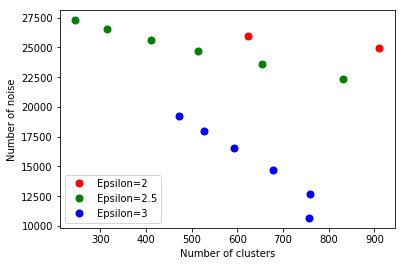

In [107]:
plt.plot(clusters2, noises2, marker='o', markersize=7, color='r', linestyle='', label='Epsilon=2')
plt.plot(clusters25, noises25, marker='o', markersize=7, color='g', linestyle='', label='Epsilon=2.5')
plt.plot(clusters3, noises3, marker='o', markersize=7, color="b", linestyle='', label='Epsilon=3')
plt.legend(fontsize='medium')
plt.xlabel('Number of clusters')
plt.ylabel("Number of noise")

In [110]:
# Best clustering for Estonian

e = 3
s = 10
clustering_et = DBSCAN(eps=e, min_samples=s).fit(distance_et)
c, n = explore_clusters(clustering_et)
print("Number of clusters: ", c)
print("Proportion of noise: ", n/distance_et.shape[0]*100)

Number of clusters:  472
Proportion of noise:  61.85613503849498


In [111]:
DataEt = {'Nouns_unique':  unique_nouns_et, 'Cluster': clustering_et.labels_}

df_clusters_et = DataFrame (DataEt, columns = ['Nouns_unique', 'Cluster'])
et_results = pd.merge(et_data, df_clusters_et, how = 'left', left_on='Nouns', right_on='Nouns_unique')
et_results = et_results.drop(columns=['Nouns_unique'])

In [112]:
et_results.head(10)

,link,node,text_join,Nouns,Cluster
0,<http::tamberi.eu::/73-ehtekaardid::null::2017...,node6883b5caa683772129c48f93ac5e99,Ehtekaart,Ehtekaart,-1
1,<https::www.paradiis.ee::/et/128-kampaania::p=...,noded2b1c726cca5417aadf2c82e333d51b6,See esinduslik aiamuFuFbel on valmistatud rom...,aiamuFuFbel lossipargi stiilis,-1
2,<https::aiakaubad.ee::/84-telgid::null::201708...,nodeaeeb8b6ba62b6f3fd2eafc75ce1f36c,Alumiiniumtoru luEbimuFuFt uD uAuDcm uDClemis...,Alumiiniumtoru luEbimuFuFt uAuDcm uDClemised t...,13
3,<https::vibes.ee::/et/13-vibraatorid::null::20...,node38302f399536504988c1d1b4703df497,Nutikas sensoriga armukuul mida saad juhtida a...,sensoriga armukuul treening lelu aru lihased t...,13
4,<https::vibes.ee::/et/750-vibraatormunad::null...,node8a81eac4ed95140bdb38ef9291fb4c8,Juhtmevaba pildiga vibraatormuna millega omale...,pildiga vibraatormuna omale vuFi naudingut pak...,0
5,<http::pood.iluraviteenused.ee::/index.php::nu...,nodeb4a66a283a8b726fcec341cf9ea3d5,LihvivaduAkaks kordauAkiiremini ja on tavaviil...,LihvivaduAkaks kordauAkiiremini tavaviilistuAn...,-1
6,<https::www.paradiis.ee::/et/6-elutuba::null::...,node56d863f1586afa4db4dccdaecf528f62,Moodsa ja lihtsa disainiga diivanvoodi CATRI...,Moodsa disainiga diivanvoodi CATRINE DIIVANVOODI,1
7,<https::www.paradiis.ee::/et/18-riidekapid::nu...,nodeb92c2de4911e9d4a8b03c5ee8be24c4,JULIETTA RIIDEKAPP S,JULIETTA RIIDEKAPP,2
8,<https::aiakaubad.ee::/::null::20170818012808,node211b954fa8bf46e912baeb731c4fb5,MuFuFblikomplekt ELEGANTE praktiline ja eleg...,MuFuFblikomplekt ELEGANTE Komplekti tugitool k...,-1
9,<https::www.paradiis.ee::/et/75-diivanvoodid::...,node918c7f59323330a5f19261daa8eff99e,ANTILIA DIIVANVOODI,ANTILIA DIIVANVOODI,1


In [113]:
et_results.to_csv('Results/et_data_dbscan.csv',index=False)